In [1]:
###packages
import numpy as np
import mne 
import os
import matplotlib.pyplot as plt
import pandas as pd

# Power plot

In [3]:
###Variables for power plot
#have to do it separetely for both cities
cities = ['Krk', 'Wwa']
nparticipants = {}#hold the information about number of the participant in each city

##variables holding all psds for plotting
psds_ec_krk = np.zeros((64,513))
psds_eo_krk = np.zeros((64,513))
psds_ec_wwa = np.zeros((63,501))
psds_eo_wwa = np.zeros((63,501))

for city in cities:
    
    read_dir = rf"D:\mgr_disc\after_EEGlab_improved_MastoidsRef\{city}_spectral_tensors"
    os.chdir(read_dir)
    files_all = os.listdir()
    files_ec = [x for x in files_all if 'ec' in x]
    files_eo = [x for x in files_all if 'eo' in x]
    
    ##number for participants for future normalisation-differs between cities
    nparticipants[city] = len(files_ec)
    
    ##upload data from every single participant
    for i in range(len(files_ec)):
        
        psd_ec = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_ec[i]))
        psd_eo = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_eo[i]))
        
        ##average across epochs
        psd_ec_average = psd_ec.average()
        psd_eo_average = psd_eo.average()
        
        ##update 
        if city == 'Krk':
            psds_ec_krk += psd_ec_average.get_data()
            psds_eo_krk += psd_eo_average.get_data()
        elif city == 'Wwa':
            psds_ec_wwa += psd_ec_average.get_data()
            psds_eo_wwa += psd_eo_average.get_data()

##normalise to have a mean
psds_ec_krk /= nparticipants['Krk']
psds_eo_krk /= nparticipants['Krk']
psds_ec_wwa /= nparticipants['Wwa']
psds_eo_wwa /= nparticipants['Wwa']

##averaging across channels
psds_ec_krk_channel_average = np.mean(psds_ec_krk,axis=0)
psds_eo_krk_channel_average = np.mean(psds_eo_krk,axis=0)
psds_ec_wwa_channel_average = np.mean(psds_ec_wwa,axis=0)
psds_eo_wwa_channel_average = np.mean(psds_eo_wwa,axis=0)

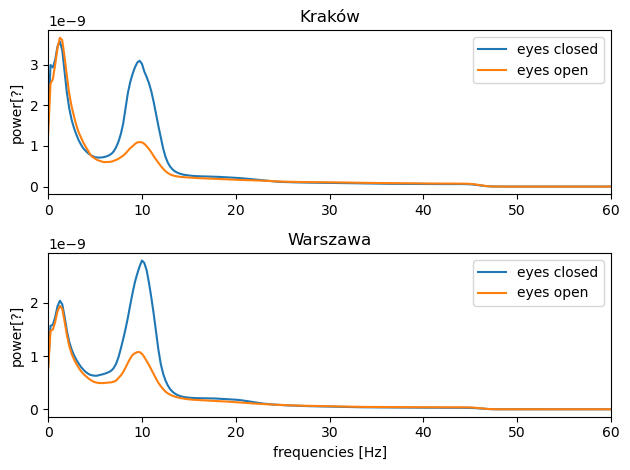

In [4]:
###plot comparing cities and eyes conditions
#getting x axis
freqs_krk = np.load(r"D:\mgr_disc\freq_vectors\freqs_krk.npy")
freqs_wwa = np.load(r"D:\mgr_disc\freq_vectors\freqs_wwa.npy")

#plots
fig,ax = plt.subplots(2,1)

ax[0].plot(freqs_krk, psds_ec_krk_channel_average, label='eyes closed')
ax[0].plot(freqs_krk, psds_eo_krk_channel_average, label='eyes open')
ax[0].legend()
ax[0].set_title('Kraków')
ax[0].set_ylabel('power[?]')
ax[0].set_xlim([0,60])


ax[1].plot(freqs_wwa, psds_ec_wwa_channel_average, label='eyes closed')
ax[1].plot(freqs_wwa, psds_eo_wwa_channel_average, label='eyes open')
ax[1].legend()
ax[1].set_title('Warszawa')
ax[1].set_ylabel('power[?]')
ax[1].set_xlabel('frequencies [Hz]')
ax[1].set_xlim([0,60])

fig.tight_layout()

plt.savefig(r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\output\plots\freq_power_plot.png")

# Barplots
## + averaged spectral dfs

In [13]:
###Dataframes powers (ec,eo) x mushroom motherfuckers

##band masks
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
#Krk
freqs_krk = np.load(r"D:\mgr_disc\freq_vectors\freqs_krk.npy")
bands_krk = {'delta':np.logical_and(freqs_krk>=1,freqs_krk<=3),
              'theta':np.logical_and(freqs_krk>=4,freqs_krk<=8),
              'alpha':np.logical_and(freqs_krk>=9,freqs_krk<=13),
              'beta':np.logical_and(freqs_krk>=14,freqs_krk<=30),
              'gamma':np.logical_and(freqs_krk>=31,freqs_krk<=45)}
#Wwa
freqs_wwa = np.load(r"D:\mgr_disc\freq_vectors\freqs_wwa.npy")
bands_wwa = {'delta':np.logical_and(freqs_wwa>=1,freqs_wwa<=3),
              'theta':np.logical_and(freqs_wwa>=4,freqs_wwa<=8),
              'alpha':np.logical_and(freqs_wwa>=9,freqs_wwa<=13),
              'beta':np.logical_and(freqs_wwa>=14,freqs_wwa<=30),
              'gamma':np.logical_and(freqs_wwa>=31,freqs_wwa<=45)}

##output dataframes
columns = ['delta_ec', 'theta_ec', 'alpha_ec', 'beta_ec', 'gamma_ec',
           'delta_eo', 'theta_eo', 'alpha_eo', 'beta_eo', 'gamma_eo']#same between cities
#Krk
os.chdir(r"D:\mgr_disc\after_EEGlab_improved_MastoidsRef2\Krk_spectral_tensors")
files_krk = os.listdir()
files_krk = files_krk[::2]#every participant has two conditions
ids_krk = ['sub-' + files_krk[x][:3] for x in range(len(files_krk))]
Krk_df = pd.DataFrame(data=np.zeros((len(ids_krk), len(columns))), index=ids_krk, columns=columns)
#Wwa
os.chdir(r"D:\mgr_disc\after_EEGlab_improved_MastoidsRef2\Wwa_spectral_tensors")
files_wwa = os.listdir()
files_wwa = files_wwa[::2]#every participant has two conditions
ids_wwa = ['sub-' + files_wwa[x][:3] for x in range(len(files_wwa))]
Wwa_df = pd.DataFrame(data=np.zeros((len(ids_wwa), len(columns))), index=ids_wwa, columns=columns)

##merge with behaviour to have the condition information
#behavioural dataframe
beh_df = pd.read_csv(r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\output\dataframes\data_beh_main_krk_wwa.csv",sep=';')
to_merge = beh_df['group']
to_merge.index = beh_df['participant_id']
#merging
Krk_df = pd.concat([Krk_df, to_merge], axis=1,join='inner')
Wwa_df = pd.concat([Wwa_df, to_merge], axis=1,join='inner')

In [14]:
### upload and average previously computed spectra -> select a band using a mask -> upload df with that average

cities = ['Krk', 'Wwa']

for city in cities:

    ##upload data from city
    read_dir = rf"D:\mgr_disc\after_EEGlab_improved_MastoidsRef2\{city}_spectral_tensors"
    os.chdir(read_dir)
    files_all = os.listdir()
    files_ec = [x for x in files_all if 'ec' in x]
    files_eo = [x for x in files_all if 'eo' in x]

    ##upload data from every single participant
    for i in range(len(files_ec)):

        participant_id = 'sub-' + files_ec[i][:3]
        
        psd_ec = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_ec[i]))
        psd_eo = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_eo[i]))
        
        ##average across epochs
        psd_ec_average = psd_ec.average()
        psd_eo_average = psd_eo.average()

        ##average across channels - I promise it's not included in mne and that's why I do it on matrices
        psd_ec_average_data = psd_ec_average.get_data()
        psd_eo_average_data = psd_eo_average.get_data()
        psd_ec_average_channels = np.mean(psd_ec_average_data,axis=0)
        psd_eo_average_channels = np.mean(psd_eo_average_data,axis=0)

        ##apply mask and average frequencies from a given band
        for band in bands:#this extracts the keys
            if city == 'Krk':
                #average frequencies from band
                mask = bands_krk[band]
                mean_power_ec_band = np.mean(psd_ec_average_channels[mask])
                mean_power_eo_band = np.mean(psd_eo_average_channels[mask])
                #update dataframe
                Krk_df.loc[participant_id,band+'_ec'] = mean_power_ec_band
                Krk_df.loc[participant_id,band+'_eo'] = mean_power_eo_band 
            elif city == 'Wwa':
                #average frequencies from band
                mask = bands_wwa[band]
                mean_power_ec_band = np.mean(psd_ec_average_channels[mask])
                mean_power_eo_band = np.mean(psd_eo_average_channels[mask])
                #update dataframe
                Wwa_df.loc[participant_id,band+'_ec'] = mean_power_ec_band
                Wwa_df.loc[participant_id,band+'_eo'] = mean_power_eo_band  
#end :)

##save
Krk_df.to_csv(r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\output\dataframes\Krk_averaged_electrodes_spectral.csv")
Wwa_df.to_csv(r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\output\dataframes\Wwa_averaged_electrodes_spectral.csv")

In [15]:
###barplots finally
#upload and divide dataframes

Krk_df = pd.read_csv(r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\output\dataframes\Krk_averaged_electrodes_spectral.csv")
Wwa_df = pd.read_csv(r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\output\dataframes\Wwa_averaged_electrodes_spectral.csv")

Krk_exp = Krk_df[Krk_df['group'] == 'e']
Krk_con = Krk_df[Krk_df['group'] == 'c']
Wwa_exp = Wwa_df[Wwa_df['group'] == 'e']
Wwa_con = Wwa_df[Wwa_df['group'] == 'c']

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

for band in bands:

    Wwa_band_eo_mean_exp = np.mean(Wwa_exp[band+'_eo'])
    Wwa_band_eo_mean_con = np.mean(Wwa_con[band+'_eo'])
    Wwa_band_ec_mean_exp = np.mean(Wwa_exp[band+'_ec'])
    Wwa_band_ec_mean_con = np.mean(Wwa_con[band+'_ec'])
    
    
    Krk_band_eo_mean_exp = np.mean(Krk_exp[band+'_eo'])
    Krk_band_eo_mean_con = np.mean(Krk_con[band+'_eo'])
    Krk_band_ec_mean_exp = np.mean(Krk_exp[band+'_ec'])
    Krk_band_ec_mean_con = np.mean(Krk_con[band+'_ec'])
    
    band_means = [Wwa_band_eo_mean_exp, Wwa_band_eo_mean_con, Wwa_band_ec_mean_exp, Wwa_band_ec_mean_con,
                 Krk_band_eo_mean_exp, Krk_band_eo_mean_con, Krk_band_ec_mean_exp, Krk_band_ec_mean_con]
    band_ranges = [0, np.max(band_means)*1.2]
    
    Xlabels = ['eyes open', 'eyes closed']
    Xaxis = np.arange(len(Xlabels))
    
    users_wwa = [Wwa_band_eo_mean_exp, Wwa_band_ec_mean_exp]
    non_users_wwa = [Wwa_band_eo_mean_con, Wwa_band_ec_mean_con]
    users_krk = [Krk_band_eo_mean_exp, Krk_band_ec_mean_exp]
    non_users_krk = [Krk_band_eo_mean_con, Krk_band_ec_mean_con]
    
    fig,ax = plt.subplots(1,2)
    
    ax[0].bar(Xaxis-.2, users_wwa, .4, label='users')
    ax[0].bar(Xaxis+.2, non_users_wwa, .4, label='non users')
    
    ax[1].bar(Xaxis-.2, users_krk, .4, label='users')
    ax[1].bar(Xaxis+.2, non_users_krk, .4, label='non users')
    
    ax[0].set_xticks(Xaxis,Xlabels)
    ax[0].set_title('Warszawa')
    ax[0].set_ylabel('moc [a.u]')
    ax[0].set_ylim(band_ranges)
    
    ax[1].set_xticks(Xaxis,Xlabels)
    ax[1].set_title('Kraków')
    ax[1].set_ylim(band_ranges)
    ax[1].get_yaxis().set_visible(False)
    ax[1].legend()
    
    fig.suptitle(band)
    
    plt.savefig(fr"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\output\plots\barplots_averaged_electrodes\{band}_bar.jpg")

# Topoplots

* Plotting function requires matrix of averaged spectral data of shape (channels,bands). Then we will feed it one band at the time.
* We also need channel names separately for each city.

In [2]:
##appropiate backend
%matplotlib qt

In [3]:
##channel names and order
#topoplot function requires info object, not a list of channels
chans_krk = mne.time_frequency.read_spectrum(r"D:\mgr_disc\after_EEGlab_improved_MastoidsRef2\Krk_spectral_tensors\101_epo_ec-psd.hdf5").info
chans_wwa = mne.time_frequency.read_spectrum(r"D:\mgr_disc\after_EEGlab_improved_MastoidsRef2\Wwa_spectral_tensors\002_epo_ec-psd.hdf5").info

nchans_krk = len(chans_krk['ch_names'])
nchans_wwa = len(chans_wwa['ch_names'])

##band masks
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
nbands = len(bands)
#Krk
freqs_krk = np.load(r"D:\mgr_disc\freq_vectors\freqs_krk.npy")
bands_krk = {'delta':np.logical_and(freqs_krk>=1,freqs_krk<=3),
              'theta':np.logical_and(freqs_krk>=4,freqs_krk<=8),
              'alpha':np.logical_and(freqs_krk>=9,freqs_krk<=13),
              'beta':np.logical_and(freqs_krk>=14,freqs_krk<=30),
              'gamma':np.logical_and(freqs_krk>=31,freqs_krk<=45)}
#Wwa
freqs_wwa = np.load(r"D:\mgr_disc\freq_vectors\freqs_wwa.npy")
bands_wwa = {'delta':np.logical_and(freqs_wwa>=1,freqs_wwa<=3),
              'theta':np.logical_and(freqs_wwa>=4,freqs_wwa<=8),
              'alpha':np.logical_and(freqs_wwa>=9,freqs_wwa<=13),
              'beta':np.logical_and(freqs_wwa>=14,freqs_wwa<=30),
              'gamma':np.logical_and(freqs_wwa>=31,freqs_wwa<=45)}

##holding the information about power from each electrode
#Krk
psd_ec_average_krk = np.zeros((nchans_krk,nbands))
psd_eo_average_krk = np.zeros((nchans_krk,nbands))
#Wwa
psd_ec_average_wwa = np.zeros((nchans_wwa,nbands))
psd_eo_average_wwa = np.zeros((nchans_wwa,nbands))
#Here should also be a third matrix for ec minus eo but there's no point of initialising it as it will be created during subtracting 

OSError: file "D:\mgr_disc\after_EEGlab_improved_MastoidsRef2\Krk_spectral_tensors\101_epo_ec-psd.hdf5" not found

In [4]:
### upload and average previously computed spectra -> select a band using a mask -> upload matrix

cities = ['Krk', 'Wwa']

for city in cities:

    ##upload data from city
    read_dir = rf"D:\mgr_disc\after_EEGlab_improved_MastoidsRef2\{city}_spectral_tensors"
    os.chdir(read_dir)
    files_all = os.listdir()
    files_ec = [x for x in files_all if 'ec' in x]
    files_eo = [x for x in files_all if 'eo' in x]

    if city == 'Krk':
        nparticipants_krk = len(files_ec)
    elif city == 'Wwa':
        nparticipants_wwa = len(files_ec)

    ##upload data from every single participant
    for i in range(len(files_ec)):
        
        psd_ec = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_ec[i]))
        psd_eo = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_eo[i]))
        
        ##average across epochs
        psd_ec_average = psd_ec.average()
        psd_eo_average = psd_eo.average()

        ##extract data 
        psd_ec_average_data = psd_ec_average.get_data()
        psd_eo_average_data = psd_eo_average.get_data()

        ##averaging powers but this time not keep all channels
        for i,band in enumerate(bands):
            if city == 'Krk':
                #apply mask
                mask = bands_krk[band]
            elif city == 'Wwa':
                mask = bands_wwa[band]
            
            psd_ec_band = psd_ec_average_data[:,mask]
            psd_eo_band = psd_eo_average_data[:,mask]
            #mean power from given band separately for each electrode
            psd_ec_band_mean = np.mean(psd_ec_band,axis=1)
            psd_eo_band_mean = np.mean(psd_eo_band,axis=1)
            #update matrix
            if city == 'Krk':
                psd_ec_average_krk[:,i] += psd_ec_band_mean
                psd_eo_average_krk[:,i] += psd_eo_band_mean
            elif city == 'Wwa':
                psd_ec_average_wwa[:,i] += psd_ec_band_mean
                psd_eo_average_wwa[:,i] += psd_eo_band_mean

##normalise
psd_ec_average_krk /= nparticipants_krk
psd_eo_average_krk /= nparticipants_krk

psd_ec_average_wwa /= nparticipants_wwa
psd_eo_average_wwa /= nparticipants_wwa

##substraction condition
psd_ec_minus_eo_average_krk = psd_ec_average_krk - psd_eo_average_krk
psd_ec_minus_eo_average_wwa = psd_ec_average_wwa - psd_eo_average_wwa

In [10]:
#topoplots krk
for band_idx,band_name in enumerate(bands):
    
    #variables holding a data from given band
    eyes_closed = psd_ec_average_krk[:,band_idx]
    eyes_open = psd_eo_average_krk[:,band_idx]
    eyes_closed_minus_open = psd_ec_minus_eo_average_krk[:,band_idx]
    eyes_closed_minus_open = eyes_closed_minus_open - np.mean(eyes_closed_minus_open)#mean centering in order to have correct scale
    
    
    #color limits for given band
    closed_and_open_scale = (np.min([eyes_closed,eyes_open]),np.max([eyes_closed,eyes_open]))
    closed_minus_open_scale = (np.min(eyes_closed_minus_open),np.max(eyes_closed_minus_open))
    
    #set up the figure
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
    #topoplots
    im,cm = mne.viz.plot_topomap(eyes_closed,chans_krk,axes=ax1,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax1.set_title('Eyes Closed', fontsize=12)
    im,cm = mne.viz.plot_topomap(eyes_open,chans_krk,axes=ax2,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax2.set_title('Eyes Open', fontsize=12)
    im_sub,cm = mne.viz.plot_topomap(eyes_closed_minus_open,chans_krk,axes=ax3,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_minus_open_scale,res=128,size=8)
    ax3.set_title('EC - EO', fontsize=12)
        
    #colorbar eyes closed and open condition
    ax_x_start = 0.05
    ax_x_width = 0.02
    ax_y_start = 0.18
    ax_y_height = 0.7
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('$\\mu V$')#,fontsize=fontsize) # title on top of colorbar
    
    #colorbar substraction condition
    ax_x_start_sub = 0.635
    ax_x_width_sub = 0.02
    ax_y_start_sub = 0.18
    ax_y_height_sub = 0.7
    cbar_ax_sub = fig.add_axes([ax_x_start_sub, ax_y_start_sub, ax_x_width_sub, ax_y_height_sub])
    clb_sub = fig.colorbar(im_sub, cax=cbar_ax_sub)
    clb_sub.ax.set_title('$\\mu V$')#,fontsize=fontsize) # title on top of colorbar
    
    #general tilte
    fig.suptitle(band_name, fontsize=20)
    
    #saving
    plt.savefig(r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\output\plots\topoplots\krk_" + str(band_name) + "_topo_mean" + ".jpg")
    
    #so I don't have to cose the figures all the time
    plt.close(fig)

In [11]:
#topoplots wwa 
for band_idx,band_name in enumerate(bands):
    
    #variables holding a data from given band
    eyes_closed = psd_ec_average_wwa[:,band_idx]
    eyes_open = psd_eo_average_wwa[:,band_idx]
    eyes_closed_minus_open = psd_ec_minus_eo_average_wwa[:,band_idx]
    eyes_closed_minus_open = eyes_closed_minus_open - np.mean(eyes_closed_minus_open)#mean centering in order to have correct scale
    
    
    #color limits for given band
    closed_and_open_scale = (np.min([eyes_closed,eyes_open]),np.max([eyes_closed,eyes_open]))
    closed_minus_open_scale = (np.min(eyes_closed_minus_open),np.max(eyes_closed_minus_open))
    
    #set up the figure
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
    #topoplots
    im,cm = mne.viz.plot_topomap(eyes_closed,chans_wwa,axes=ax1,names=chans_wwa['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax1.set_title('Eyes Closed', fontsize=12)
    im,cm = mne.viz.plot_topomap(eyes_open,chans_wwa,axes=ax2,names=chans_wwa['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax2.set_title('Eyes Open', fontsize=12)
    im_sub,cm = mne.viz.plot_topomap(eyes_closed_minus_open,chans_wwa,axes=ax3,names=chans_wwa['ch_names'],show=False,
                                 vlim=closed_minus_open_scale,res=128,size=8)
    ax3.set_title('EC - EO', fontsize=12)
        
    #colorbar eyes closed and open condition
    ax_x_start = 0.05
    ax_x_width = 0.02
    ax_y_start = 0.18
    ax_y_height = 0.7
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('$\\mu V$')#,fontsize=fontsize) # title on top of colorbar
    
    #colorbar substraction condition
    ax_x_start_sub = 0.635
    ax_x_width_sub = 0.02
    ax_y_start_sub = 0.18
    ax_y_height_sub = 0.7
    cbar_ax_sub = fig.add_axes([ax_x_start_sub, ax_y_start_sub, ax_x_width_sub, ax_y_height_sub])
    clb_sub = fig.colorbar(im_sub, cax=cbar_ax_sub)
    clb_sub.ax.set_title('$\\mu V$')#,fontsize=fontsize) # title on top of colorbar
    
    #general tilte
    fig.suptitle(band_name, fontsize=20)
    
    #saving
    plt.savefig(r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\output\plots\topoplots\wwa_" + str(band_name) + "topo_mean" + ".jpg")
    
    #so I don't have to cose the figures all the time
    plt.close(fig)

# Topo electrode selection

In [2]:
##appropiate backend
%matplotlib qt

In [11]:
##channel names and order
#topoplot function requires info object, not a list of channels
chans_krk = mne.time_frequency.read_spectrum(r"D:\mgr_disc\Final\Krk_spectral_tensors\101_epo_ec-psd.hdf5").info
chans_wwa = mne.time_frequency.read_spectrum(r"D:\mgr_disc\Final\Wwa_spectral_tensors\002_epo_ec-psd.hdf5").info

nchans_krk = len(chans_krk['ch_names'])
nchans_wwa = len(chans_wwa['ch_names'])

##band masks
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
nbands = len(bands)
#Krk
freqs_krk = np.load(r"D:\mgr_disc\freq_vectors\freqs_krk.npy")
bands_krk = {'delta':np.logical_and(freqs_krk>=1,freqs_krk<=3),
              'theta':np.logical_and(freqs_krk>=4,freqs_krk<=8),
              'alpha':np.logical_and(freqs_krk>=9,freqs_krk<=13),
              'beta':np.logical_and(freqs_krk>=14,freqs_krk<=30),
              'gamma':np.logical_and(freqs_krk>=31,freqs_krk<=45)}
#Wwa
freqs_wwa = np.load(r"D:\mgr_disc\freq_vectors\freqs_wwa.npy")
bands_wwa = {'delta':np.logical_and(freqs_wwa>=1,freqs_wwa<=3),
              'theta':np.logical_and(freqs_wwa>=4,freqs_wwa<=8),
              'alpha':np.logical_and(freqs_wwa>=9,freqs_wwa<=13),
              'beta':np.logical_and(freqs_wwa>=14,freqs_wwa<=30),
              'gamma':np.logical_and(freqs_wwa>=31,freqs_wwa<=45)}

##holding the information about power from each electrode
#Krk
psd_ec_average_krk = np.zeros((nchans_krk,nbands))
psd_eo_average_krk = np.zeros((nchans_krk,nbands))
#Wwa
psd_ec_average_wwa = np.zeros((nchans_wwa,nbands))
psd_eo_average_wwa = np.zeros((nchans_wwa,nbands))
#both cities combined
psd_ec_average_global = np.zeros((nchans_wwa,nbands))
psd_eo_average_global = np.zeros((nchans_wwa,nbands))

### cell below applies only to global matrices

In [12]:
##unify channel order

#channels in general match, but they have different orders across cities
#np.setdiff1d(chans_krk['ch_names'],chans_wwa['ch_names'])
#dict(zip(chans_krk['ch_names'],chans_wwa['ch_names']))

#raw channel names 
#It has to be this weird because mne chan list for plots has to be a mne info object 
#here I just work with channel names and order
chans_krk_list = chans_krk['ch_names']  # Extract list of channel names
chans_wwa_list = chans_wwa['ch_names'] 

# Convert to NumPy array for indexing
chans_krk_arr = np.array(chans_krk_list)
chans_wwa_arr = np.array(chans_wwa_list)

# Find the sorting indices
sort_indices = np.argsort([chans_krk_list.index(ch) for ch in chans_wwa_list])

# Apply sorting
wwa_chans_with_krk_order = chans_wwa_arr[sort_indices]

#Verify
#dict(zip(chans_krk_list, wwa_chans_with_krk_order))
#sort_indices

In [13]:
### upload and average previously computed spectra -> select a band using a mask -> upload matrix

cities = ['Krk', 'Wwa']

for city in cities:

    ##upload data from city
    read_dir = rf"D:\mgr_disc\Final\{city}_spectral_tensors"
    os.chdir(read_dir)
    files_all = os.listdir()
    files_ec = [x for x in files_all if 'ec' in x]
    files_eo = [x for x in files_all if 'eo' in x]

    if city == 'Krk':
        nparticipants_krk = len(files_ec)
    elif city == 'Wwa':
        nparticipants_wwa = len(files_ec)

    ##upload data from every single participant
    for participant in range(len(files_ec)):
        
        psd_ec = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_ec[participant]))
        psd_eo = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_eo[participant]))
        
        ##average across epochs
        psd_ec_average = psd_ec.average()
        psd_eo_average = psd_eo.average()

        ##extract data 
        psd_ec_average_data = psd_ec_average.get_data()
        psd_eo_average_data = psd_eo_average.get_data()

        ##averaging powers but this time not keeping all channels
        for i,band in enumerate(bands):
            if city == 'Krk':
                #apply mask
                mask = bands_krk[band]
            elif city == 'Wwa':
                mask = bands_wwa[band]
            
            psd_ec_band = psd_ec_average_data[:,mask]
            psd_eo_band = psd_eo_average_data[:,mask]
            #mean power from given band separately for each electrode
            psd_ec_band_mean = np.mean(psd_ec_band,axis=1)
            psd_eo_band_mean = np.mean(psd_eo_band,axis=1)
            #update matrix
            psd_ec_average_global[:,i] += psd_ec_band_mean
            psd_eo_average_global[:,i] += psd_eo_band_mean
            
            if city == 'Krk':
                psd_ec_average_krk[:,i] += psd_ec_band_mean
                psd_eo_average_krk[:,i] += psd_eo_band_mean
                #since global matrix have krk channel order we don't have to do anything
                psd_ec_average_global[:,i] += psd_ec_band_mean
                psd_eo_average_global[:,i] += psd_eo_band_mean
                
            elif city == 'Wwa':
                psd_ec_average_wwa[:,i] += psd_ec_band_mean
                psd_eo_average_wwa[:,i] += psd_eo_band_mean
                #reordering wwa channel order cause global matrices follow krk channel order
                psd_ec_average_global[:,i] += psd_ec_band_mean[sort_indices]
                psd_eo_average_global[:,i] += psd_eo_band_mean[sort_indices]

##normalise
nparticipants_global = (nparticipants_krk + nparticipants_wwa)
psd_ec_average_global /= nparticipants_global
psd_eo_average_global /= nparticipants_global

psd_ec_average_krk /= nparticipants_krk
psd_eo_average_krk /= nparticipants_krk

psd_ec_average_wwa /= nparticipants_wwa
psd_eo_average_wwa /= nparticipants_wwa

#convert units and detrend
#bacuse of some ungodly reasons loop doesn't work here 
psd_ec_average_global *= (10**12)
psd_ec_average_global = 10 * np.log10(psd_ec_average_global)

psd_eo_average_global *= (10**12)
psd_eo_average_global = 10 * np.log10(psd_eo_average_global)

psd_ec_average_krk *= (10**12)
psd_ec_average_krk = 10 * np.log10(psd_ec_average_krk)

psd_eo_average_krk *= (10**12)
psd_eo_average_krk = 10 * np.log10(psd_eo_average_krk)

psd_ec_average_wwa *= (10**12)
psd_ec_average_wwa = 10 * np.log10(psd_ec_average_wwa)

psd_eo_average_wwa *= (10**12)
psd_eo_average_wwa = 10 * np.log10(psd_eo_average_wwa)

##substraction condition
psd_eo_minus_ec_average_global = psd_eo_average_global - psd_ec_average_global#Here substraction is inverted!!!!!
psd_ec_minus_eo_average_krk = psd_ec_average_krk - psd_eo_average_krk
psd_ec_minus_eo_average_wwa = psd_ec_average_wwa - psd_eo_average_wwa

## save these badboys
np.savetxt(
    r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\all_channels\output\dataframes\band_x_electrodes_averaged\psd_ec_average_global.csv",
    psd_ec_average_global, delimiter = ",")
np.savetxt(
    r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\all_channels\output\dataframes\band_x_electrodes_averaged\psd_eo_average_global.csv",
    psd_eo_average_global, delimiter = ",")
np.savetxt(
    r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\all_channels\output\dataframes\band_x_electrodes_averaged\psd_eo_minus_ec_average_global.csv",
    psd_eo_minus_ec_average_global, delimiter = ",")

In [22]:
#topoplots krk
for band_idx,band_name in enumerate(bands):
    
    #variables holding a data from given band
    eyes_closed = psd_ec_average_krk[:,band_idx]
    eyes_open = psd_eo_average_krk[:,band_idx]
    eyes_closed_minus_open = psd_ec_minus_eo_average_krk[:,band_idx]
    eyes_closed_minus_open = eyes_closed_minus_open - np.mean(eyes_closed_minus_open)#mean centering in order to have correct scale
    
    
    #color limits for given band
    closed_and_open_scale = (np.min([eyes_closed,eyes_open]),np.max([eyes_closed,eyes_open]))
    closed_minus_open_scale = (-np.max(eyes_closed_minus_open),np.max(eyes_closed_minus_open))
    
    #set up the figure
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
    #topoplots
    im,cm = mne.viz.plot_topomap(eyes_closed,chans_krk,axes=ax1,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax1.set_title('Eyes Closed', fontsize=12)
    im,cm = mne.viz.plot_topomap(eyes_open,chans_krk,axes=ax2,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax2.set_title('Eyes Open', fontsize=12)
    im_sub,cm = mne.viz.plot_topomap(eyes_closed_minus_open,chans_krk,axes=ax3,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_minus_open_scale,res=128,size=8)
    ax3.set_title('EC - EO', fontsize=12)
        
    #colorbar eyes closed and open condition
    ax_x_start = 0.05
    ax_x_width = 0.02
    ax_y_start = 0.18
    ax_y_height = 0.7
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('$\\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar
    
    #colorbar substraction condition
    ax_x_start_sub = 0.63
    ax_x_width_sub = 0.02
    ax_y_start_sub = 0.18
    ax_y_height_sub = 0.7
    cbar_ax_sub = fig.add_axes([ax_x_start_sub, ax_y_start_sub, ax_x_width_sub, ax_y_height_sub])
    clb_sub = fig.colorbar(im_sub, cax=cbar_ax_sub)
    clb_sub.ax.set_title('$\\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar
    
    #general tilte
    fig.suptitle(band_name, fontsize=20)
    
    #saving
    plt.savefig(
        r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\all_channels\output\plots\topo_roi_selection\band_x_condition_cities_separately\median_krk_" + str(band_name) + "_topo_mean" + ".jpg")
    
    #so I don't have to cose the figures all the time
    plt.close(fig)

In [21]:
#topoplots wwa 
for band_idx,band_name in enumerate(bands):
    
    #variables holding a data from given band
    eyes_closed = psd_ec_average_wwa[:,band_idx]
    eyes_open = psd_eo_average_wwa[:,band_idx]
    eyes_closed_minus_open = psd_ec_minus_eo_average_wwa[:,band_idx]
    eyes_closed_minus_open = eyes_closed_minus_open - np.mean(eyes_closed_minus_open)#mean centering in order to have correct scale
    
    
    #color limits for given band
    closed_and_open_scale = (np.min([eyes_closed,eyes_open]),np.max([eyes_closed,eyes_open]))
    closed_minus_open_scale = (-np.max(eyes_closed_minus_open),np.max(eyes_closed_minus_open))
    
    #set up the figure
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
    #topoplots
    im,cm = mne.viz.plot_topomap(eyes_closed,chans_wwa,axes=ax1,names=chans_wwa['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax1.set_title('Eyes Closed', fontsize=12)
    im,cm = mne.viz.plot_topomap(eyes_open,chans_wwa,axes=ax2,names=chans_wwa['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax2.set_title('Eyes Open', fontsize=12)
    im_sub,cm = mne.viz.plot_topomap(eyes_closed_minus_open,chans_wwa,axes=ax3,names=chans_wwa['ch_names'],show=False,
                                 vlim=closed_minus_open_scale,res=128,size=8)
    ax3.set_title('EC - EO', fontsize=12)
        
    #colorbar eyes closed and open condition
    ax_x_start = 0.05
    ax_x_width = 0.02
    ax_y_start = 0.18
    ax_y_height = 0.7
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('$\\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar
    
    #colorbar substraction condition
    ax_x_start_sub = 0.63
    ax_x_width_sub = 0.02
    ax_y_start_sub = 0.18
    ax_y_height_sub = 0.7
    cbar_ax_sub = fig.add_axes([ax_x_start_sub, ax_y_start_sub, ax_x_width_sub, ax_y_height_sub])
    clb_sub = fig.colorbar(im_sub, cax=cbar_ax_sub)
    clb_sub.ax.set_title('$\\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar
    
    #general tilte
    fig.suptitle(band_name, fontsize=20)
    
    #saving
    plt.savefig(
        r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\all_channels\output\plots\topo_roi_selection\band_x_condition_cities_separately\median_wwa_" + str(band_name) + "topo_mean" + ".jpg")
    
    #so I don't have to cose the figures all the time
    plt.close(fig)

## Now just two plots: band krk and band wwa

In [5]:
for band_idx,band_name in enumerate(bands):

    #averaged eyes condition from both cities 
    krk = (psd_ec_average_krk[:,band_idx] + psd_eo_average_krk[:,band_idx]) / 2
    wwa = (psd_ec_average_wwa[:,band_idx] + psd_eo_average_wwa[:,band_idx]) / 2

    #color limits
    #numpy is stupid as hell and I have to first calculate local minimum instead of passing just np.min([krk,wwa]) because krk has one channel more
    lim_krk = (np.min(krk),np.max(krk))
    lim_wwa = (np.min(wwa),np.max(wwa))
    color_scale = (np.min([lim_krk,lim_wwa]),np.max([lim_krk,lim_wwa]))

    #set up the figure
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,6))
    #topoplots
    im,cm = mne.viz.plot_topomap(krk,chans_krk,axes=ax1,names=chans_krk['ch_names'],show=False,
                                 vlim=color_scale,res=128,size=8)
    ax1.set_title('Kraków', fontsize=12)
    
    im,cm = mne.viz.plot_topomap(wwa,chans_wwa,axes=ax2,names=chans_wwa['ch_names'],show=False,
                                 vlim=color_scale,res=128,size=8)
    ax2.set_title('Warszawa', fontsize=12)

    #colorbar eyes closed and open condition
    ax_x_start = 0.05
    ax_x_width = 0.02
    ax_y_start = 0.18
    ax_y_height = 0.7
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('$dB \\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar

    #general tilte
    fig.suptitle(band_name, fontsize=20)
    
    #saving
    plt.savefig(
        r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\all_channels\output\plots\topo_roi_selection\band_x_cities\city_comparison_" + str(band_name) + "topo_mean" + ".jpg")
    
    #so I don't have to cose the figures all the time
    plt.close(fig)

## Paweł asks for city colour scales separately

In [14]:
for band_idx,band_name in enumerate(bands):

    #averaged eyes condition from both cities 
    krk = (psd_ec_average_krk[:,band_idx] + psd_eo_average_krk[:,band_idx]) / 2
    wwa = (psd_ec_average_wwa[:,band_idx] + psd_eo_average_wwa[:,band_idx]) / 2

    #color limits
    #numpy is stupid as hell and I have to first calculate local minimum instead of passing just np.min([krk,wwa]) because krk has one channel more
    lim_krk = (np.min(krk),np.max(krk))
    lim_wwa = (np.min(wwa),np.max(wwa))

    #set up the figure
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,6))
    #topoplots
    im_krk,cm_krk = mne.viz.plot_topomap(krk,chans_krk,axes=ax1,names=chans_krk['ch_names'],show=False,
                                 vlim=lim_krk,res=128,size=8)
    ax1.set_title('Kraków', fontsize=12)
    
    im_wwa,cm_wwa = mne.viz.plot_topomap(wwa,chans_wwa,axes=ax2,names=chans_wwa['ch_names'],show=False,
                                 vlim=lim_wwa,res=128,size=8)
    ax2.set_title('Warszawa', fontsize=12)

    #colorbar krk
    ax_x_start = 0.05
    ax_x_width = 0.02
    ax_y_start = 0.18
    ax_y_height = 0.7
    cbar_ax_krk = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb_krk = fig.colorbar(im_krk, cax=cbar_ax_krk)
    clb_krk.ax.set_title('$dB \\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar

    #colorbar wwa
    ax_x_start_wwa = 0.535
    ax_x_width_wwa = 0.02
    ax_y_start_wwa = 0.18
    ax_y_height_wwa = 0.7
    cbar_ax_wwa = fig.add_axes([ax_x_start_wwa, ax_y_start_wwa, ax_x_width_wwa, ax_y_height_wwa])
    clb_wwa = fig.colorbar(im_wwa, cax=cbar_ax_wwa)
    clb_wwa.ax.set_title('$\\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar

    #general tilte
    fig.suptitle(band_name.capitalize(), fontsize=20)
    
    #saving
    plt.savefig(
        r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\all_channels\output\plots\topo_roi_selection\topo_city_scale_separately\city_comparison_" + str(band_name) + "topo_mean" + ".jpg")
    
    #so I don't have to cose the figures all the time
    plt.close(fig)

## Band x condition with combined cities

In [8]:
for band_idx,band_name in enumerate(bands):
    
    #variables holding a data from given band
    eyes_closed = psd_ec_average_global[:,band_idx]
    eyes_open = psd_eo_average_global[:,band_idx]
    eyes_open_minus_closed = psd_eo_minus_ec_average_global[:,band_idx]
    eyes_open_minus_closed = eyes_open_minus_closed - np.mean(eyes_open_minus_closed)#mean centering in order to have correct scale
    
    
    #color limits for given band
    closed_and_open_scale = (np.min([eyes_closed,eyes_open]),np.max([eyes_closed,eyes_open]))
    closed_minus_open_scale = (np.min(eyes_open_minus_closed),np.max(eyes_open_minus_closed))
    
    #set up the figure
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
    #topoplots
    im,cm = mne.viz.plot_topomap(eyes_closed,chans_krk,axes=ax1,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax1.set_title('Eyes Closed', fontsize=12)
    
    im,cm = mne.viz.plot_topomap(eyes_open,chans_krk,axes=ax2,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax2.set_title('Eyes Open', fontsize=12)
    
    im_sub,cm = mne.viz.plot_topomap(eyes_open_minus_closed,chans_krk,axes=ax3,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_minus_open_scale,res=128,size=8)
    ax3.set_title('EO - EC', fontsize=12)
        
    #colorbar eyes closed and open condition
    ax_x_start = 0.05
    ax_x_width = 0.02
    ax_y_start = 0.18
    ax_y_height = 0.7
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('$\\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar
    
    #colorbar substraction condition
    ax_x_start_sub = 0.63
    ax_x_width_sub = 0.02
    ax_y_start_sub = 0.18
    ax_y_height_sub = 0.7
    cbar_ax_sub = fig.add_axes([ax_x_start_sub, ax_y_start_sub, ax_x_width_sub, ax_y_height_sub])
    clb_sub = fig.colorbar(im_sub, cax=cbar_ax_sub)
    clb_sub.ax.set_title('$\\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar
    
    #general tilte
    fig.suptitle(band_name, fontsize=20)
    
    #saving
    plt.savefig(
        r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\all_channels\output\plots\topo_roi_selection\band_x_condition_cities_combined\_" + str(band_name) + "_topo_mean" + ".jpg")
    
    #so I don't have to cose the figures all the time
    plt.close(fig)

## Median of electrode activity

In [15]:
##channel names and order
#topoplot function requires info object, not a list of channels
chans_krk = mne.time_frequency.read_spectrum(r"D:\mgr_disc\Final\Krk_spectral_tensors\101_epo_ec-psd.hdf5").info
chans_wwa = mne.time_frequency.read_spectrum(r"D:\mgr_disc\Final\Wwa_spectral_tensors\002_epo_ec-psd.hdf5").info

nchans_krk = len(chans_krk['ch_names'])
nchans_wwa = len(chans_wwa['ch_names'])

nparticipants_krk = len([x for x in os.listdir(r"D:\mgr_disc\Final\Krk_spectral_tensors") if 'ec' in x])
nparticipants_wwa = len([x for x in os.listdir(r"D:\mgr_disc\Final\Wwa_spectral_tensors") if 'ec' in x])
nparticipants_global = nparticipants_krk + nparticipants_wwa

##band masks
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
nbands = len(bands)
#Krk
freqs_krk = np.load(r"D:\mgr_disc\freq_vectors\freqs_krk.npy")
bands_krk = {'delta':np.logical_and(freqs_krk>=1,freqs_krk<=3),
              'theta':np.logical_and(freqs_krk>=4,freqs_krk<=8),
              'alpha':np.logical_and(freqs_krk>=9,freqs_krk<=13),
              'beta':np.logical_and(freqs_krk>=14,freqs_krk<=30),
              'gamma':np.logical_and(freqs_krk>=31,freqs_krk<=45)}
#Wwa
freqs_wwa = np.load(r"D:\mgr_disc\freq_vectors\freqs_wwa.npy")
bands_wwa = {'delta':np.logical_and(freqs_wwa>=1,freqs_wwa<=3),
              'theta':np.logical_and(freqs_wwa>=4,freqs_wwa<=8),
              'alpha':np.logical_and(freqs_wwa>=9,freqs_wwa<=13),
              'beta':np.logical_and(freqs_wwa>=14,freqs_wwa<=30),
              'gamma':np.logical_and(freqs_wwa>=31,freqs_wwa<=45)}

##holding the information about power from each electrode
#Krk
psd_ec_average_krk = np.zeros((nchans_krk,nbands,nparticipants_krk))
psd_eo_average_krk = np.zeros((nchans_krk,nbands,nparticipants_krk))
#Wwa
psd_ec_average_wwa = np.zeros((nchans_wwa,nbands,nparticipants_wwa))
psd_eo_average_wwa = np.zeros((nchans_wwa,nbands,nparticipants_wwa))
#both cities combined
psd_ec_average_global = np.zeros((nchans_wwa,nbands,nparticipants_global))
psd_eo_average_global = np.zeros((nchans_wwa,nbands,nparticipants_global))

#Pawełs' new idea for substraction
#matrix_sub = np.zeros((nchans_wwa,nbands,nparticipants_global))

In [16]:
##unify channel order

#channels in general match, but they have different orders across cities
#np.setdiff1d(chans_krk['ch_names'],chans_wwa['ch_names'])
#dict(zip(chans_krk['ch_names'],chans_wwa['ch_names']))

#raw channel names 
#It has to be this weird because mne chan list for plots has to be a mne info object 
#here I just work with channel names and order
chans_krk_list = chans_krk['ch_names']  # Extract list of channel names
chans_wwa_list = chans_wwa['ch_names'] 

# Convert to NumPy array for indexing
chans_krk_arr = np.array(chans_krk_list)
chans_wwa_arr = np.array(chans_wwa_list)

# Find the sorting indices
sort_indices = np.argsort([chans_krk_list.index(ch) for ch in chans_wwa_list])

# Apply sorting
wwa_chans_with_krk_order = chans_wwa_arr[sort_indices]

#Verify
#dict(zip(chans_krk_list, wwa_chans_with_krk_order))
#sort_indices

In [17]:
### upload and average previously computed spectra -> select a band using a mask -> upload matrix

cities = ['Krk', 'Wwa']

#another counter because participant != id of a person in global matrices after Krk iterations
participant_glob = 0

for city in cities:

    ##upload data from city
    read_dir = rf"D:\mgr_disc\Final\{city}_spectral_tensors"
    os.chdir(read_dir)
    files_all = os.listdir()
    files_ec = [x for x in files_all if 'ec' in x]
    files_eo = [x for x in files_all if 'eo' in x]

    ##upload data from every single participant
    for participant in range(len(files_ec)):
        
        psd_ec = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_ec[participant]))
        psd_eo = mne.time_frequency.read_spectrum(os.path.join(read_dir, files_eo[participant]))
        
        ##average across epochs
        psd_ec_average = psd_ec.average()
        psd_eo_average = psd_eo.average()

        ##extract data 
        psd_ec_average_data = psd_ec_average.get_data()
        psd_eo_average_data = psd_eo_average.get_data()

        ##averaging powers but this time not keeping all channels
        for i,band in enumerate(bands):
            if city == 'Krk':
                #apply mask
                mask = bands_krk[band]
            elif city == 'Wwa':
                mask = bands_wwa[band]
            
            psd_ec_band = psd_ec_average_data[:,mask]
            psd_eo_band = psd_eo_average_data[:,mask]
            #mean power from given band separately for each electrode
            psd_ec_band_mean = np.mean(psd_ec_band,axis=1)
            psd_eo_band_mean = np.mean(psd_eo_band,axis=1)
            
            #update matrix
            if city == 'Krk':
                psd_ec_average_krk[:,i,participant] = psd_ec_band_mean
                psd_eo_average_krk[:,i,participant] = psd_eo_band_mean
                #since global matrix have krk channel order we don't have to do anything
                psd_ec_average_global[:,i,participant_glob] = psd_ec_band_mean
                psd_eo_average_global[:,i,participant_glob] = psd_eo_band_mean
                #matrix_sub[:,i,participant_glob] = psd_eo_band_mean - psd_ec_band_mean
                
            elif city == 'Wwa':
                psd_ec_average_wwa[:,i,participant] = psd_ec_band_mean
                psd_eo_average_wwa[:,i,participant] = psd_eo_band_mean
                #reordering wwa channel order cause global matrices follow krk channel order
                psd_ec_average_global[:,i,participant_glob] = psd_ec_band_mean[sort_indices]
                psd_eo_average_global[:,i,participant_glob] = psd_eo_band_mean[sort_indices]
                #matrix_sub[:,i,participant_glob] = psd_eo_band_mean[sort_indices] - psd_ec_band_mean[sort_indices]

        #update second counter
        participant_glob += 1

##take the median
psd_ec_average_global = np.median(psd_ec_average_global,axis=2)
psd_eo_average_global = np.median(psd_eo_average_global,axis=2)

psd_ec_average_krk = np.median(psd_ec_average_krk,axis=2)
psd_eo_average_krk = np.median(psd_eo_average_krk,axis=2)

psd_ec_average_wwa = np.median(psd_ec_average_wwa,axis=2)
psd_eo_average_wwa = np.median(psd_eo_average_wwa,axis=2)

#matrix_sub= np.median(matrix_sub,axis=2)

#convert units and detrend
#bacuse of some ungodly reasons loop doesn't work here 
psd_ec_average_global *= (10**12)
psd_ec_average_global = 10 * np.log10(psd_ec_average_global)

psd_eo_average_global *= (10**12)
psd_eo_average_global = 10 * np.log10(psd_eo_average_global)

psd_ec_average_krk *= (10**12)
psd_ec_average_krk = 10 * np.log10(psd_ec_average_krk)

psd_eo_average_krk *= (10**12)
psd_eo_average_krk = 10 * np.log10(psd_eo_average_krk)

psd_ec_average_wwa *= (10**12)
psd_ec_average_wwa = 10 * np.log10(psd_ec_average_wwa)

psd_eo_average_wwa *= (10**12)
psd_eo_average_wwa = 10 * np.log10(psd_eo_average_wwa)

#matrix_sub *= (10**12)
#matrix_sub = 10 * np.log10(matrix_sub)

##substraction condition
psd_eo_minus_ec_average_global = psd_eo_average_global - psd_ec_average_global#Here substraction is inverted!!!!!
psd_ec_minus_eo_average_krk = psd_ec_average_krk - psd_eo_average_krk
psd_ec_minus_eo_average_wwa = psd_ec_average_wwa - psd_eo_average_wwa

In [28]:
for band_idx,band_name in enumerate(bands):
    
    #variables holding a data from given band
    eyes_closed = psd_ec_average_global[:,band_idx]
    eyes_open = psd_eo_average_global[:,band_idx]
    eyes_open_minus_closed = eyes_open - eyes_closed
    #eyes_open_minus_closed = eyes_open_minus_closed - np.mean(eyes_open_minus_closed)#mean centering in order to have correct scale
    
    
    #color limits for given band
    closed_and_open_scale = (np.min([eyes_closed,eyes_open]),np.max([eyes_closed,eyes_open]))

    kolordupa = None
    
    if band_name == 'alpha':
        closed_minus_open_scale = (-6,-.001)
        kolordupa = "PuBu_r"

    elif band_name == 'delta':
        closed_minus_open_scale = (-.8,.8)

    elif band_name == 'gamma':
        closed_minus_open_scale = (0.1,1.6)#-.07
        kolordupa = "Reds"

    elif band_name == 'theta':
        closed_minus_open_scale = (-1.5,-.001)
        kolordupa = "PuBu_r"

    elif band_name == 'beta':
        closed_minus_open_scale = (-1.2,1.2)
    
    #set up the figure
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
    #topoplots
    im,cm = mne.viz.plot_topomap(eyes_closed,chans_krk,axes=ax1,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax1.set_title('Eyes Closed', fontsize=12)
    
    im,cm = mne.viz.plot_topomap(eyes_open,chans_krk,axes=ax2,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_and_open_scale,res=128,size=8)
    ax2.set_title('Eyes Open', fontsize=12)
    
    im_sub,cm = mne.viz.plot_topomap(eyes_open_minus_closed,chans_krk,axes=ax3,names=chans_krk['ch_names'],show=False,
                                 vlim=closed_minus_open_scale,res=128,size=8,cmap=kolordupa)
    ax3.set_title('EO - EC', fontsize=12)
        
    #colorbar eyes closed and open condition
    ax_x_start = 0.05
    ax_x_width = 0.02
    ax_y_start = 0.18
    ax_y_height = 0.7
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('$\\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar
    
    #colorbar substraction condition
    ax_x_start_sub = 0.63
    ax_x_width_sub = 0.02
    ax_y_start_sub = 0.18
    ax_y_height_sub = 0.7
    cbar_ax_sub = fig.add_axes([ax_x_start_sub, ax_y_start_sub, ax_x_width_sub, ax_y_height_sub])
    clb_sub = fig.colorbar(im_sub, cax=cbar_ax_sub)
    clb_sub.ax.set_title('$\\frac{\\mu V^2} {Hz}$')#,fontsize=fontsize) # title on top of colorbar
    
    #general tilte
    fig.suptitle(band_name.capitalize(), fontsize=20)
    
    #saving
    plt.savefig(
        r"C:\Users\stasi\OneDrive\Pulpit\proj_mgr\all_channels\output\plots\topo_roi_selection\band_x_condition_cities_combined\median_" + str(band_name) + "_topo_mean" + ".jpg")
    
    #so I don't have to cose the figures all the time
    plt.close(fig)